## Import packages

In [1]:
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from concurrent.futures import ProcessPoolExecutor
import itertools

## Define differentiable Gillespie algorithm

In [2]:
# Define the stoichiometry matrix for the reactions
stoic_matrix = torch.tensor([[2.0, 0.0],    # Reaction 1: Promoter state goes from -1 to +1
                             [0.0, 1.0],    # Reaction 2: mRNA is produced
                             [-2.0, 0.0],   # Reaction 3: Promoter state goes from +1 to -1
                             [0.0, -1.0]])  # Reaction 4: Degradation of mRNA

# Define a function to compute the state jump
def state_jump(reaction_index, stoic_matrix):
    """
    Calculate state jump vector based on the selected reaction index and stoichiometry matrix, where, 
    state vector -> state vector + state jump vector.

    Arguments:
        reaction_index: Selected reaction index
        stoic_matrix: Stoichiometry matrix

    Returns:
        State jump vector
    """
    return torch.sum(stoic_matrix * (torch.exp(-b_inv* (reaction_index - torch.arange(stoic_matrix.shape[0]))**2)).view(-1, 1), dim=0)

# Define a function to select the reaction based on reaction selection thresholds
def reaction_selection(breaks, random_num):
    """
    Select reaction based on the transition points and a random number. Transition points are 
    given by the ratio of cumulative sum of rates and the total rate.

    Arguments:
        breaks: Transition points between [0,1]
        random_num: Random number in [0,1]

    Returns:
        Index of the next reaction
    """
    return torch.sum(torch.sigmoid(a_inv * (random_num - breaks)))

# Define the Gillespie simulation function
def gillespie_simulation(kon, r, g, num_simulations, sim_time, a_inv, b_inv, c):
    """
    Perform differentiable Gillespie simulation for a 2-state promoter model.
    
    Arguments:
        kon: Rate of promoter switching from -1 to +1.
        r: Rate of mRNA production.
        g: Rate of mRNA degradation.
        num_simulations: Number of simulations to run.
        sim_time: Simulation time.
        a_inv: Inverse parameter for reaction selection.
        b_inv : Inverse parameter for state jump calculation.
        c: Sigmoid slope parameter for propensities.
        
    Returns:
        mean_final_state: Mean of the mRNA levels at the end of the simulation.
        variance: Variance of the mRNA levels at the end of the simulation.
    """
    # Initialize random seed for reproducibility
    random_seed = torch.randint(1, 10000000, (1,))
    torch.manual_seed(random_seed)
    final_states = 0.0
    final_states_squared = 0.0

    # Main simulation loop
    for j in range(num_simulations):
        # Initial 'levels':
        # The first component of 'levels' is the promoter state, initialized to -1
        # The second component of 'levels' is the mRNA level, initailized to 0.
        levels = torch.stack([torch.tensor(-1.0), torch.tensor(0.0)])
        current_time = 0.0

        # Main simulation loop
        while current_time < sim_time:
            # Calculate reaction propensities
            propensities = torch.stack([kon*torch.sigmoid(-c*levels[0]),                 # Rate of promoter state switching from -1 to +1
                                        r*torch.sigmoid(-c*levels[0]),                   # Rate of mRNA production
                                        torch.tensor([1.0])*torch.sigmoid(c*levels[0]),  # Rate of promoter state switching from +1 to -1
                                        g*levels[1]])                                    # Rate of mRNA degradation

            # Calculate total propensity
            total_propensity = propensities.sum()

            # Generate a random number to determine time to next reaction
            dt = -torch.log(torch.rand(1)) / total_propensity
            current_time += dt.item()

            # Check if the simulation exceeds sim_time. If it exceeds, quit the simulation.
            if current_time >= sim_time:
                break

            # Update state
            breaks = (propensities[:-1] / total_propensity).cumsum(dim=0)
            reaction_index = reaction_selection(breaks, torch.rand(1))
            levels = levels + state_jump(reaction_index, stoic_matrix)
            levels[1] = torch.relu(levels[1]) 

        # Accumulate final states after each sumulation
        final_states += levels[1]
        final_states_squared += levels[1] ** 2

    # Calculate mean and variance of mRNA levels (from the accumulated final states)
    mean_final_state = final_states / num_simulations
    variance = final_states_squared / num_simulations - mean_final_state ** 2

    # Return mean mRNA level and variance
    return mean_final_state, variance

# Define a function to write data to a file
def write_to_file(filename, *args):
    with open(filename, 'a') as file:
        file.write(' '.join(map(str, args)) + '\n')
        
# Define the loss function 
def loss_function(mean_final_state, variance, target_mean, target_std):
    """
    Calculates the mean squared error of the simulation results against data
    """
    return (mean_final_state - target_mean) ** 2 + (variance ** 0.5 - target_std) ** 2

## Load the learned parameter values and the true parameter values

In [3]:
# Load the learning progress data
file_path = 'onoff_model_random_samples_with_deg.txt'  
data = np.loadtxt(file_path)  

# Initialize dictionaries to store the parameter values with minimum loss
min_rows = {}

# Iterate through each row in the dataset
for row in data:
    index = int(row[0])
    # Track the first row for each unique index
    if index not in first_rows:
        first_rows[index] = row
    # Update the minimum row for the index as needed
    if index not in min_rows or row[-1] < min_rows[index][-1]:
        min_rows[index] = row

# Extract the values of the parameters, mean, and variance 
diff_gillespie_min = [row[[2, 3, 4, 5, 6]] for row in min_rows.values()]
diff_gillespie_min = np.array(diff_gillespie_min)

# Load true values of the parameters, mean, and variance
true_values = np.load("random_rates.npy")[:len(diff_gillespie_min), :]

## Compute loss function around the learned parameter values (parallelly)

In [ ]:
%%time
ind=6 # Index for selecting parameters

# Define target standard deviation and mean from true_values
target_std= true_values[ind, -1]
target_mean= true_values[ind, -2]

# Define hyperparameters for simulation
a_inv = 200.0
b_inv = 20.0
c = 20.0
sim_time = 10.0
num_simulations = 50

# Wrapper function to perform simulation with different parameter values
def simulation_wrapper(args):
    x, y, fixed_param_value, fixed_param_name, target_mean, target_std = args
    
    # Convert inputs to tensors if gillespie_simulation expects tensors
    x_tensor = torch.tensor([x], dtype=torch.float32)
    y_tensor = torch.tensor([y], dtype=torch.float32)
    fixed_param_tensor = torch.tensor([fixed_param_value], dtype=torch.float32)
    
    # Call gillespie_simulation function based on fixed parameter name
    if fixed_param_name == 'g':
        mean, variance = gillespie_simulation(x_tensor, y_tensor, fixed_param_tensor, num_simulations, sim_time, a_inv, b_inv, c)
    elif fixed_param_name == 'r':
        mean, variance = gillespie_simulation(x_tensor, fixed_param_tensor, y_tensor, num_simulations, sim_time, a_inv, b_inv, c)
    else: 
        mean, variance = gillespie_simulation(fixed_param_tensor, x_tensor, y_tensor, num_simulations, sim_time, a_inv, b_inv, c)
    
    # Calculate loss based on simulated mean and variance
    loss = loss_function(mean.item(), variance.item(), target_mean, target_std)
    return loss

# Function to generate heat map using parallel processing
def generate_heat_map_parallel(x_values, y_values, fixed_param_value, fixed_param_name, target_mean, target_std):
    with ProcessPoolExecutor() as executor:
        # Prepare arguments for simulation_wrapper
        args = [(x, y, fixed_param_value, fixed_param_name, target_mean, target_std) for x, y in itertools.product(x_values, y_values)]
        # Use parallel processing to perform simulations for all parameter combinations
        Z = np.array(list(executor.map(simulation_wrapper, args))).reshape((len(y_values), len(x_values)))
    return Z

n = 25 # Number of points on an axis of grid
param_range = 0.9 # Sets the range of the parameters around the learned values

# Define parameter ranges 
k_on_center = diff_gillespie_min[ind, 0]
r_center = diff_gillespie_min[ind, 1]
g_center = diff_gillespie_min[ind, 2]

k_on_values = np.linspace(k_on_center * (1 - param_range), k_on_center * (1 + 1.1*param_range), n)
r_values = np.linspace(r_center * (1 - param_range), r_center * (1 + 0.5*param_range), n)
g_values = np.linspace(g_center * (1 - param_range), g_center * (1 + 0.5*param_range), n)

# Generate heat maps in parallel for different parameter combinations
Z_kon_r = generate_heat_map_parallel(k_on_values, r_values, g_center, 'g', target_mean, target_std)
Z_kon_g = generate_heat_map_parallel(k_on_values, g_values, r_center, 'r', target_mean, target_std)
Z_r_g = generate_heat_map_parallel(r_values, g_values, k_on_center, 'k_on', target_mean, target_std)

# Save the generated heat maps and parameter values to files
np.savetxt('Z_kon_r.txt', Z_kon_r)
np.savetxt('Z_kon_g.txt', Z_kon_g)
np.savetxt('Z_r_g.txt', Z_r_g)
np.savetxt('k_on_values.txt', k_on_values)
np.savetxt('r_values.txt', r_values)
np.savetxt('g_values.txt', g_values)

## Plot heat maps

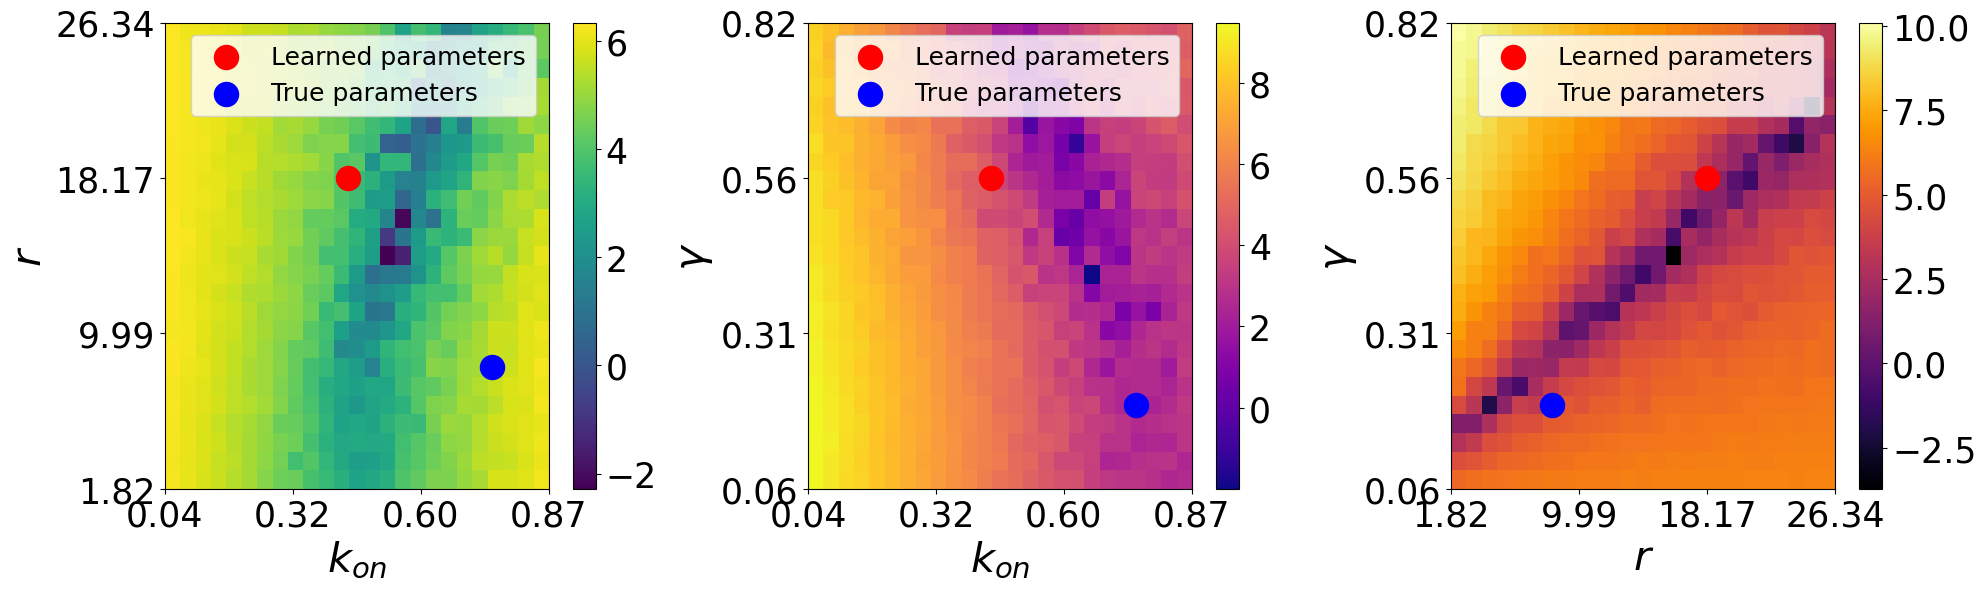

In [5]:
ind=6 # Index for selecting parameters 

# Create subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Set global tick size
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

# Set global label size
plt.rcParams['axes.labelsize'] = 30

# Define colormaps for each subplot
cmaps = ['viridis', 'plasma', 'inferno']

# Load data from files
Z_kon_r = np.loadtxt('Z_kon_r.txt')
Z_kon_g = np.loadtxt('Z_kon_g.txt')
Z_r_g = np.loadtxt('Z_r_g.txt')
k_on_values = np.loadtxt('k_on_values.txt')
r_values = np.loadtxt('r_values.txt')
g_values = np.loadtxt('g_values.txt')

# Define number of ticks for each subplot
num_ticks = 4

# Optimal values obtained from optimization
opt_params = [diff_gillespie_min[ind, 0], diff_gillespie_min[ind, 1], diff_gillespie_min[ind, 2]]

# True parameter values for comparison
true_params = [true_values[ind, 0], true_values[ind, 1], true_values[ind, 2]]

# Scatter point labels
scatter_labels1 = ['Learned parameters', 'Learned parameters', 'Learned parameters']
scatter_labels2 = ['True parameters', 'True parameters', 'True parameters']

# Iterate over each subplot and corresponding data
for ax, Z, x_values, y_values, x_label, y_label, cmap, scatter_labels1, opt_param, scatter_labels2, true_param in zip(
    axs,
    [Z_kon_r, Z_kon_g, Z_r_g],
    [k_on_values, k_on_values, r_values],
    [r_values, g_values, g_values],
    ['$k_{on}$', '$k_{on}$', '$r$'],
    ['$r$', '$\\gamma$', '$\\gamma$'],
    cmaps,
    scatter_labels1,
    [(opt_params[0], opt_params[1]), (opt_params[0], opt_params[2]), (opt_params[1], opt_params[2])], scatter_labels2, 
    [(true_params[0], true_params[1]), (true_params[0], true_params[2]), (true_params[1], true_params[2])]
):
    
    # Create heat map
    im = ax.imshow(np.log(Z), cmap=cmap, aspect='auto', origin='lower',
                   extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()])

    # Set the ticks at the center of each cell
    ax.set_xticks(np.linspace(x_values.min(), x_values.max(), num_ticks))
    ax.set_yticks(np.linspace(y_values.min(), y_values.max(), num_ticks))

    # Format tick labels
    ax.set_xticklabels([f'{x:.2f}' for x in np.linspace(x_values.min(), x_values.max(), num_ticks)])
    ax.set_yticklabels([f'{y:.2f}' for y in np.linspace(y_values.min(), y_values.max(), num_ticks)])

    # Set axis labels
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Plot scatter points for optimal and true parameter values
    ax.scatter(*opt_param, color='red', s=300, zorder=5, label=scatter_labels1)
    ax.scatter(*true_param, color='blue', s=300, zorder=5, label=scatter_labels2)

    # Create colorbar
    cbar = fig.colorbar(im, ax=ax)

    # Show legend
    ax.legend()
    ax.legend(fontsize=18) 

# Adjust layout and save plot
plt.tight_layout()
plt.savefig('heat_map_loss_fun.pdf', bbox_inches='tight')
plt.show()
